## Imports

In [12]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy import stats
import glob
import re
from scipy import stats
from scipy.stats import wilcoxon

import pickle
from sklearn.manifold import TSNE

## Create Heatmap Displays

PHQ8_NoInterest:
  Absolute Average Difference: 0.429
  Number of N/A Questions: 27
  Accuracy on Available Questions: 0.429
  Overall Accuracy: 0.146
--------------------------------------------------
PHQ8_Depressed:
  Absolute Average Difference: 0.567
  Number of N/A Questions: 11
  Accuracy on Available Questions: 0.567
  Overall Accuracy: 0.415
--------------------------------------------------
PHQ8_Sleep:
  Absolute Average Difference: 0.615
  Number of N/A Questions: 2
  Accuracy on Available Questions: 0.615
  Overall Accuracy: 0.585
--------------------------------------------------
PHQ8_Tired:
  Absolute Average Difference: 0.808
  Number of N/A Questions: 15
  Accuracy on Available Questions: 0.808
  Overall Accuracy: 0.512
--------------------------------------------------
PHQ8_Appetite:
  Absolute Average Difference: 0.500
  Number of N/A Questions: 39
  Accuracy on Available Questions: 0.500
  Overall Accuracy: 0.024
--------------------------------------------------
PHQ8

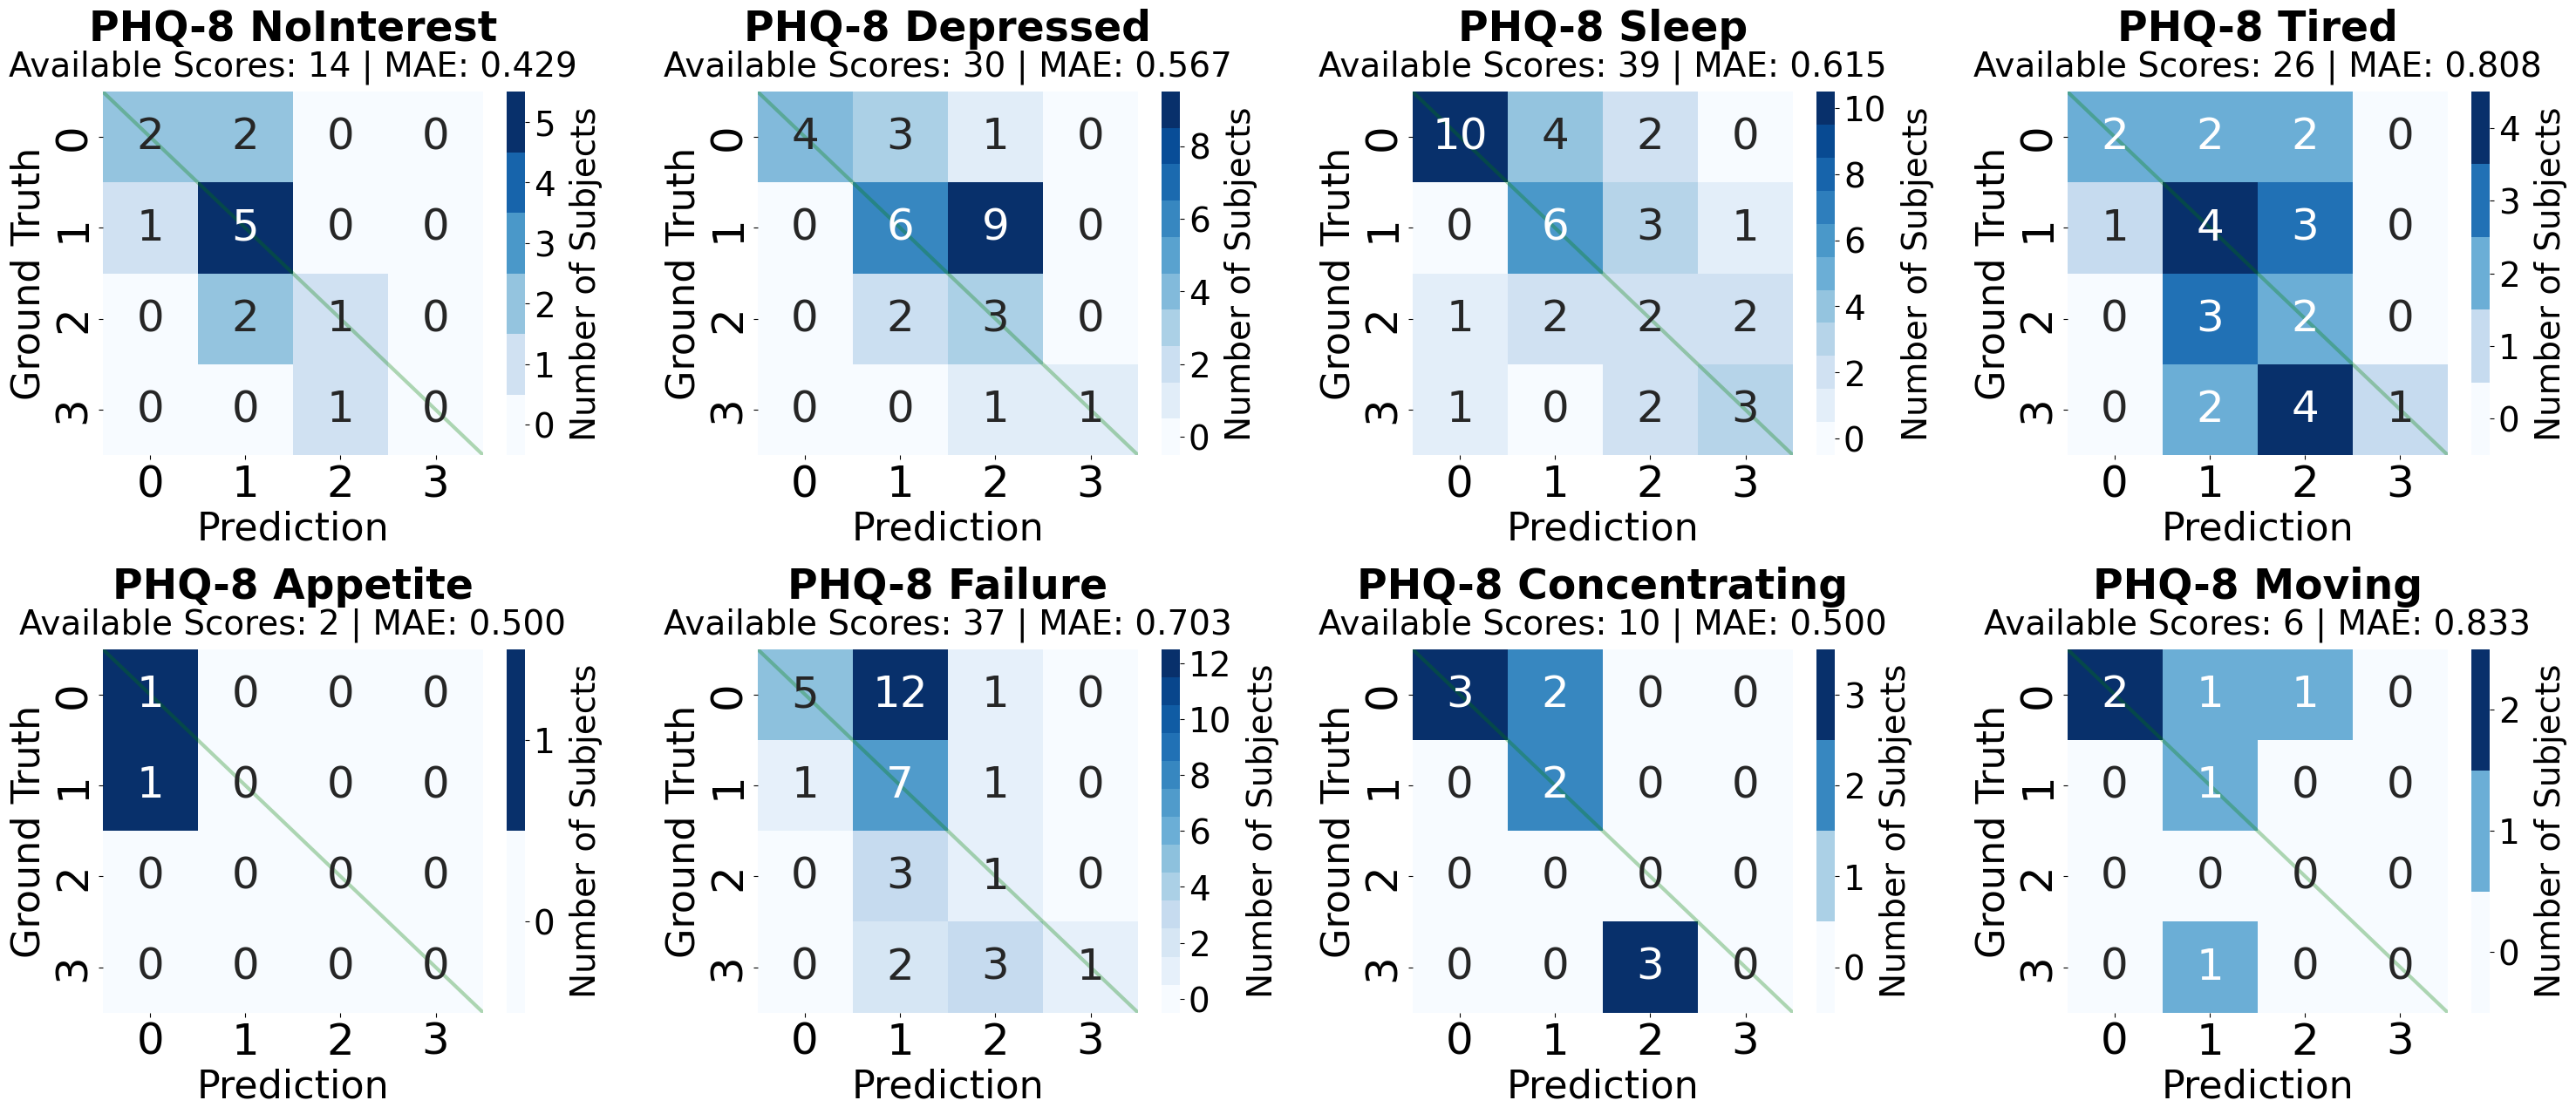

In [13]:
def load_jsonl(file_path):
    """
    Loads the jsonl file

    Parameters
    ----------
    file_path : string
        The path to the jsonl file

    Returns
    -------
    list
        A list of dictionaries, where each dictionary represents 
        a JSON object from a line in the JSONL file
    """
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def load_ground_truth(csv_file1, csv_file2):
    """
    Loads and combines two CSV files containing ground truth data

    Parameters
    ----------
    csv_file1 : string
        Path to the first CSV file
    csv_file2 : string
        Path to the second CSV file

    Returns
    -------
    pandas dataframe
        A combined dataframe containing data from both CSV files
    """
    df1 = pd.read_csv(csv_file1)
    df2 = pd.read_csv(csv_file2)
    # Combine the csv files together instead of switching back and forth for participants
    combined_df = pd.concat([df1, df2], ignore_index=True)
    return combined_df

#zero_shot_data = load_jsonl(r"/data/users2/agreene46/ai-psychiatrist/analysis_output/zero_shot_results_detailed.jsonl")
few_shot_data = load_jsonl(r"/data/users2/agreene46/ai-psychiatrist/TEST_analysis_output/chunk_8_step_2_examples_2_embedding_results_analysis.jsonl")

predicted_data = few_shot_data
ground_truth_df = load_ground_truth(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/dev_split_Depression_AVEC2017.csv", r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/train_split_Depression_AVEC2017.csv")

# PHQ8 question names
phq8_questions = [
    'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
    'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving'
]

def extract_scores_for_question(predicted_data, ground_truth_df, question):
    """
    Grabs predicted and ground truth scores for a given PHQ8 question

    Parameters
    ----------
    predicted_data : list
        List of dictionaries containing predicted scores for participants
    ground_truth_df : pandas dataframe
        DataFrame containing ground truth scores with participant IDs
    question : string
        Name of the PHQ8 question to extract scores for

    Returns
    -------
    tuple
        A tuple containing:
        - predicted_scores (list): List of predicted scores as integers
        - ground_truth_scores (list): List of ground truth scores
        - participant_ids (list): List of participant IDs for matched entries
        - na_count (int): Number of entries with N/A predicted scores
    """

    predicted_scores = []
    ground_truth_scores = []
    participant_ids = []
    na_count = 0
    
    for entry in predicted_data:
        participant_id = entry['participant_id']
        
        gt_row = ground_truth_df[ground_truth_df['Participant_ID'] == participant_id]
        
        if not gt_row.empty:
            if question in entry:
                question_data = entry[question]
                score = question_data.get('score', 'N/A')
                
                if score == "N/A":
                    na_count += 1
                    continue
                else:
                    pred_score = int(score)
            else:
                na_count += 1
                continue
            
            # Get ground truth score
            gt_score = gt_row.iloc[0][question]
            
            predicted_scores.append(pred_score)
            ground_truth_scores.append(gt_score)
            participant_ids.append(participant_id)
    
    return predicted_scores, ground_truth_scores, participant_ids, na_count

def create_heatmap_with_na(predicted_scores, ground_truth_scores, question_name, na_count):
    """
    Creates a confusion matrix and calculates accuracy metrics for predicted vs ground truth scores

    Parameters
    ----------
    predicted_scores : list
        List of predicted scores as integers
    ground_truth_scores : list
        List of ground truth scores as integers
    question_name : string
        Name of the question (used for labeling)
    na_count : int
        Number of N/A predictions for this question

    Returns
    -------
    tuple
        A tuple containing:
        - cm (numpy.ndarray): Confusion matrix for scores 0-3
        - na_count (int): Number of N/A predictions
        - accuracy_available (float): Accuracy MAE
    """
    # Filter out NaN values
    valid_indices = []
    for i in range(len(predicted_scores)):
        if not (pd.isna(predicted_scores[i]) or pd.isna(ground_truth_scores[i])):
            valid_indices.append(i)
    
    # Create filtered arrays with only valid (non-NaN) values
    filtered_predicted = [predicted_scores[i] for i in valid_indices]
    filtered_ground_truth = [ground_truth_scores[i] for i in valid_indices]
    
    # Only proceed if we have valid data
    if len(filtered_predicted) == 0:
        # Return empty confusion matrix and NaN accuracy if no valid data
        cm = np.zeros((4, 4), dtype=int)
        accuracy_available = np.nan
        return cm, na_count, accuracy_available
    
    cm = confusion_matrix(filtered_ground_truth, filtered_predicted, labels=[0, 1, 2, 3])
    
    predicted_array = np.array(filtered_predicted)
    ground_truth_array = np.array(filtered_ground_truth)
    absolute_differences = np.abs(predicted_array - ground_truth_array)
    avg_absolute_diff = np.mean(absolute_differences)
    accuracy_available = avg_absolute_diff # Regular MAE non normalized

    return cm, na_count, accuracy_available

fig, axes = plt.subplots(2, 4, figsize=(30, 13))
axes = axes.flatten()

title_fontsize = 34
subtitle_fontsize = 28
label_fontsize = 32
tick_fontsize = 36
colorbar_fontsize = 28

for i, question in enumerate(phq8_questions):
    predicted_scores, ground_truth_scores, participant_ids, na_count = extract_scores_for_question(
        predicted_data, ground_truth_df, question
    )
    
    cm, na_count, accuracy_available = create_heatmap_with_na(predicted_scores, ground_truth_scores, question, na_count)
    
    n_bins = np.max(cm) + 1 if np.max(cm) > 0 else 1
    cmap = plt.get_cmap('Blues', n_bins)
    
    # Create heatmap on the subplot with discrete colormap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=[0, 1, 2, 3], 
                yticklabels=[0, 1, 2, 3],
                ax=axes[i], annot_kws={'size': tick_fontsize})
    
    cbar = axes[i].collections[0].colorbar
    if n_bins > 1 and n_bins < 9:
        cbar.set_ticks(np.arange((n_bins-1)/(2*n_bins), n_bins-1, (n_bins-1)/n_bins))
        cbar.set_ticklabels(range(n_bins))
    elif n_bins >= 9:
        cbar.set_ticks(np.arange((n_bins-1)/(2*n_bins), n_bins-1, 2*(n_bins-1)/n_bins))
        cbar.set_ticklabels(range(0, n_bins, 2))
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    cbar.set_label('Number of Subjects', labelpad=12, fontsize=colorbar_fontsize)
    
    axes[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    axes[i].set_xlabel('Prediction', fontsize=label_fontsize)
    axes[i].set_ylabel('Ground Truth', fontsize=label_fontsize)
    
    question_title = question.replace('PHQ8_', 'PHQ-8 ')
    total_with_gt = len(predicted_scores) + na_count
    available_scores = total_with_gt - na_count

    axes[i].set_title(question_title, fontsize=title_fontsize, fontweight='bold', pad=42)

    subtitle = f'Available Scores: {available_scores} | MAE: {accuracy_available:.3f}'
    axes[i].text(0.5, 1.02, subtitle, transform=axes[i].transAxes,
                ha='center', va='bottom', fontsize=subtitle_fontsize)
    
    axes[i].plot([4.5, -0.5], [4.5, -0.5], 'g-', linewidth=3, alpha=0.3)
    
    total_participants_with_gt = len(predicted_scores) + na_count
    percent_not_na = (total_participants_with_gt - na_count) / total_participants_with_gt
    overall_accuracy = accuracy_available * percent_not_na
    
    print(f"{question}:")
    print(f"  Absolute Average Difference: {np.mean(np.abs(np.array(predicted_scores) - np.array(ground_truth_scores))):.3f}")
    print(f"  Number of N/A Questions: {na_count}")
    print(f"  Accuracy on Available Questions: {accuracy_available:.3f}")
    print(f"  Overall Accuracy: {overall_accuracy:.3f}")
    print("-" * 50)

# Calculate and print overall averages
all_maes = []
all_na_counts = []

for question in phq8_questions:
    predicted_scores, ground_truth_scores, participant_ids, na_count = extract_scores_for_question(
        predicted_data, ground_truth_df, question
    )
    
    cm, na_count, accuracy_available = create_heatmap_with_na(predicted_scores, ground_truth_scores, question, na_count)
    
    if not np.isnan(accuracy_available):
        all_maes.append(accuracy_available)
    all_na_counts.append(na_count)

print("=" * 50)
print("OVERALL AVERAGES:")
print(f"Total Average MAE across all questions: {np.mean(all_maes)}")
print(f"Total Average N/A Predictions per question: {np.mean(all_na_counts)}")
print("=" * 50)

plt.tight_layout(pad=1.5)
plt.savefig(r"/data/users2/agreene46/heatmap_output.pdf", bbox_inches='tight', dpi=300)
#plt.savefig("heatmap_chunk_8_step_2_examples_2.pdf", bbox_inches='tight')
# plt.show()

for question in phq8_questions:
    predicted_scores, ground_truth_scores, participant_ids, na_count = extract_scores_for_question(
        predicted_data, ground_truth_df, question
    )
    create_heatmap_with_na(predicted_scores, ground_truth_scores, question, na_count)

## MAE Zero Shot vs Few Shot Graph

Few-shot data: 41 entries
Few-shot unique participants: 41
Zero-shot data (filtered): 41 entries
Average Zero-shot MAE: 0.79594340
Average Few-shot MAE: 0.61929388



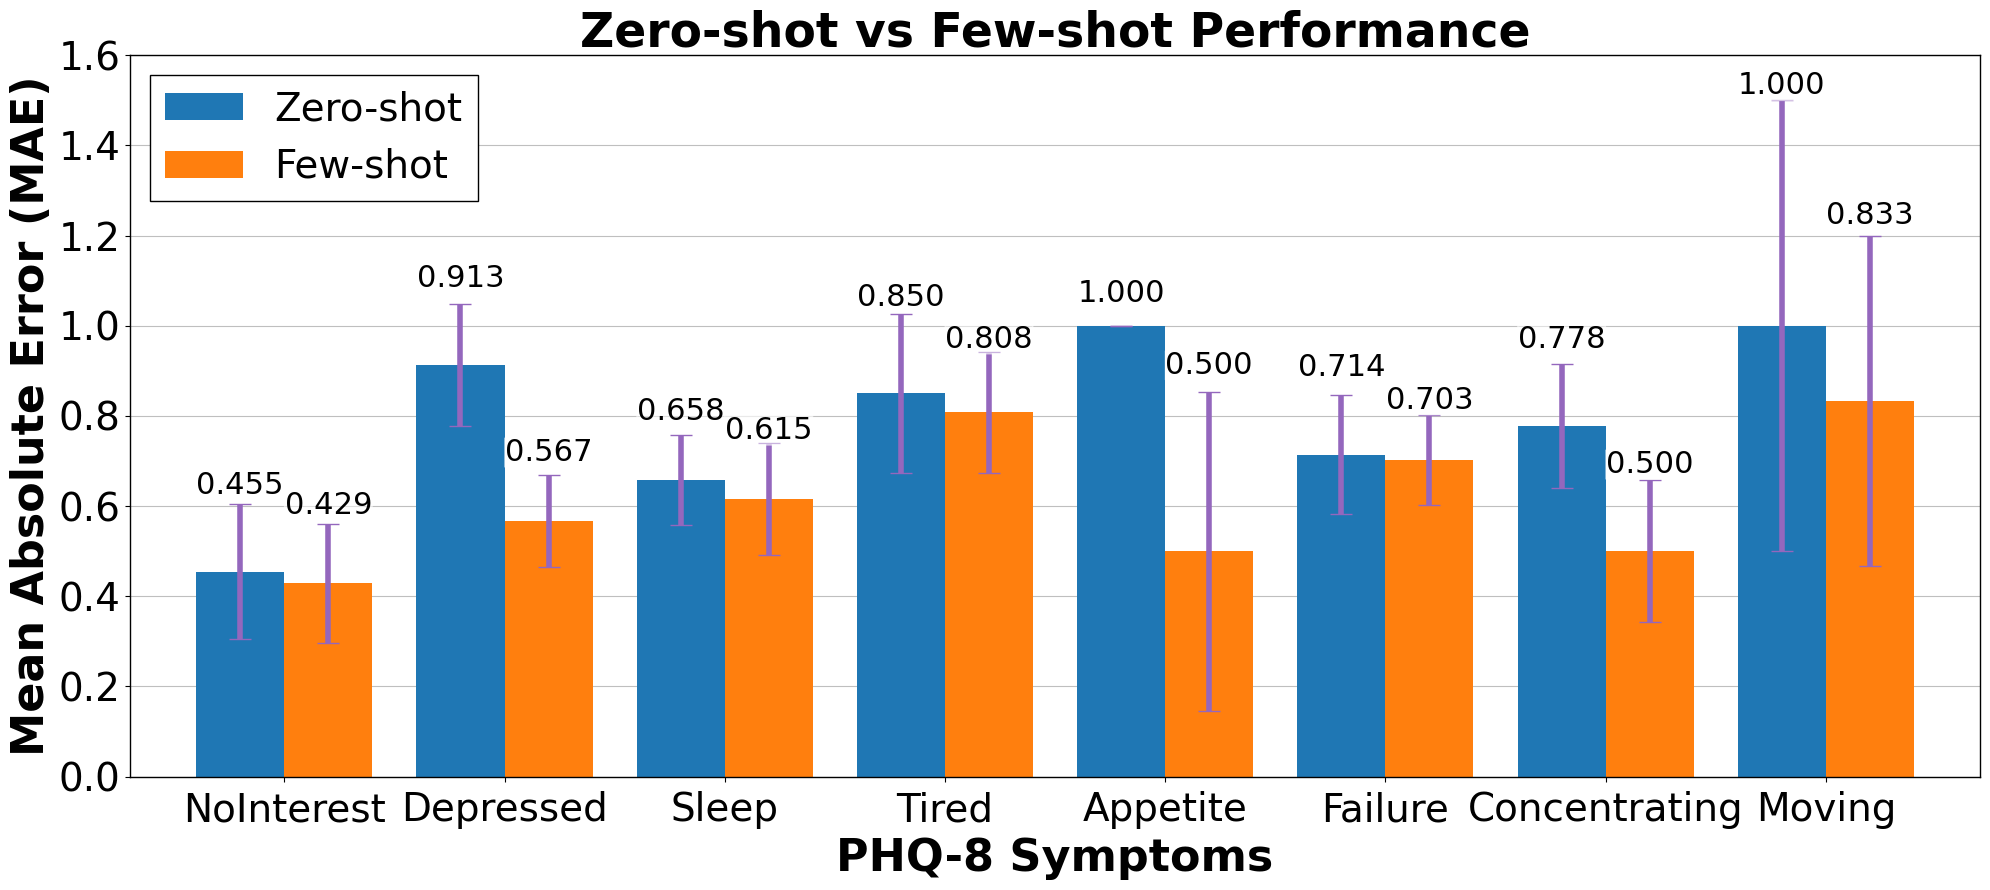

MAE Summary:
--------------------------------------------------
NoInterest:
  Zero-shot MAE: 0.455 ± 0.150
  Few-shot MAE: 0.429 ± 0.132
  Improvement: 0.026
--------------------------------------------------
Depressed:
  Zero-shot MAE: 0.913 ± 0.136
  Few-shot MAE: 0.567 ± 0.102
  Improvement: 0.346
--------------------------------------------------
Sleep:
  Zero-shot MAE: 0.658 ± 0.100
  Few-shot MAE: 0.615 ± 0.124
  Improvement: 0.043
--------------------------------------------------
Tired:
  Zero-shot MAE: 0.850 ± 0.177
  Few-shot MAE: 0.808 ± 0.133
  Improvement: 0.042
--------------------------------------------------
Appetite:
  Zero-shot MAE: 1.000 ± 0.000
  Few-shot MAE: 0.500 ± 0.354
  Improvement: 0.500
--------------------------------------------------
Failure:
  Zero-shot MAE: 0.714 ± 0.132
  Few-shot MAE: 0.703 ± 0.100
  Improvement: 0.012
--------------------------------------------------
Concentrating:
  Zero-shot MAE: 0.778 ± 0.139
  Few-shot MAE: 0.500 ± 0.158
  Impr

In [17]:
def load_jsonl_filtered(few_shot_path, zero_shot_path):
    """
    Load JSONL files with participant ID filtering.
    First loads few-shot data, then loads only matching participants from zero-shot data.
    
    Args:
        few_shot_path: Path to few-shot JSONL file
        zero_shot_path: Path to zero-shot JSONL file
    
    Returns:
        tuple: (few_shot_data, filtered_zero_shot_data)
    """
    # Load few-shot data
    few_shot_data = []
    with open(few_shot_path, 'r') as f:
        for line in f:
            few_shot_data.append(json.loads(line))
    
    # Extract participant IDs from few-shot data
    few_shot_participant_ids = set()
    for entry in few_shot_data:
        few_shot_participant_ids.add(entry['participant_id'])
    
    # Load zero-shot data, filtering by participant IDs
    filtered_zero_shot_data = []
    with open(zero_shot_path, 'r') as f:
        for line in f:
            entry = json.loads(line)
            if entry['participant_id'] in few_shot_participant_ids:
                filtered_zero_shot_data.append(entry)
    
    print(f"Few-shot data: {len(few_shot_data)} entries")
    print(f"Few-shot unique participants: {len(few_shot_participant_ids)}")
    print(f"Zero-shot data (filtered): {len(filtered_zero_shot_data)} entries")
    
    return few_shot_data, filtered_zero_shot_data

# Load the data with filtering
few_shot_data, zero_shot_data = load_jsonl_filtered(
    r"/data/users2/agreene46/ai-psychiatrist/TEST_analysis_output/chunk_8_step_2_examples_2_embedding_results_analysis.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/analysis_output/zero_shot_results_detailed.jsonl"
)

def calculate_mae_and_se(zero_shot_data, few_shot_data, ground_truth_df, question):
    """
    Calculate Mean Absolute Error (MAE) and standard error for zero-shot and few-shot predictions.

    Args:
        zero_shot_data: List of dictionaries containing zero-shot predictions with participant IDs
        few_shot_data: List of dictionaries containing few-shot predictions with participant IDs
        ground_truth_df: DataFrame containing ground truth scores with 'Participant_ID' column
        question: String identifier for the specific question/metric to evaluate

    Returns:
        tuple: (zero_shot_mae, zero_shot_se, few_shot_mae, few_shot_se)
            - zero_shot_mae: Mean absolute error for zero-shot predictions
            - zero_shot_se: Standard error for zero-shot predictions  
            - few_shot_mae: Mean absolute error for few-shot predictions
            - few_shot_se: Standard error for few-shot predictions
            Returns np.nan for any metric if no valid predictions are available
"""
    zero_shot_dict = {}
    few_shot_dict = {}
    
    # Collect zero-shot predictions
    for entry in zero_shot_data:
        participant_id = entry['participant_id']
        if question in entry:
            score = entry[question].get('score', 'N/A')
            if score != "N/A":
                try:
                    zero_shot_dict[participant_id] = int(score)
                except ValueError:
                    continue
    
    # Collect few-shot predictions
    for entry in few_shot_data:
        participant_id = entry['participant_id']
        if question in entry:
            score = entry[question].get('score', 'N/A')
            if score != "N/A":
                try:
                    few_shot_dict[participant_id] = int(score)
                except ValueError:
                    continue
    
    # Calculate errors
    zero_shot_errors = []
    few_shot_errors = []
    
    # Calculate errors for zero-shot
    for participant_id, pred_score in zero_shot_dict.items():
        gt_row = ground_truth_df[ground_truth_df['Participant_ID'] == participant_id]
        if not gt_row.empty:
            ground_truth_score = gt_row[question].iloc[0]
            if not pd.isna(ground_truth_score):
                zero_shot_errors.append(abs(pred_score - ground_truth_score))
    
    # Calculate errors for few-shot
    for participant_id, pred_score in few_shot_dict.items():
        gt_row = ground_truth_df[ground_truth_df['Participant_ID'] == participant_id]
        if not gt_row.empty:
            ground_truth_score = gt_row[question].iloc[0]
            if not pd.isna(ground_truth_score):
                few_shot_errors.append(abs(pred_score - ground_truth_score))
    
    # Calculate MAE and SE using actual sample sizes
    zero_shot_mae = np.mean(zero_shot_errors) if zero_shot_errors else np.nan
    few_shot_mae = np.mean(few_shot_errors) if few_shot_errors else np.nan
    
    # Use actual number of valid responses for SE calculation
    zero_shot_n = len(zero_shot_errors)
    few_shot_n = len(few_shot_errors)
    
    zero_shot_se = np.std(zero_shot_errors) / np.sqrt(zero_shot_n) if zero_shot_n > 0 else np.nan
    few_shot_se = np.std(few_shot_errors) / np.sqrt(few_shot_n) if few_shot_n > 0 else np.nan
    
    return zero_shot_mae, zero_shot_se, few_shot_mae, few_shot_se


# Calculate MAE and SE for each question
zero_shot_maes = []
zero_shot_ses = [] 
few_shot_maes = []
few_shot_ses = []

for question in phq8_questions:
    zs_mae, zs_se, fs_mae, fs_se = calculate_mae_and_se(
        zero_shot_data, few_shot_data, ground_truth_df, question)
    
    zero_shot_maes.append(zs_mae)
    zero_shot_ses.append(zs_se) 
    few_shot_maes.append(fs_mae)
    few_shot_ses.append(fs_se)

print(f"Average Zero-shot MAE: {np.nanmean(zero_shot_maes):.8f}")
print(f"Average Few-shot MAE: {np.nanmean(few_shot_maes):.8f}")
print()

fig, ax = plt.subplots(figsize=(20, 9))

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

x = np.arange(len(phq8_questions))
width = 0.4

colors = plt.cm.tab10.colors

bars1 = ax.bar(x - width/2, zero_shot_maes, width, label='Zero-shot', 
               color=colors[0], yerr=zero_shot_ses, capsize=8, 
               error_kw={'ecolor': colors[4], 'elinewidth': 4})
bars2 = ax.bar(x + width/2, few_shot_maes, width, label='Few-shot', 
               color=colors[1], yerr=few_shot_ses, capsize=8,
               error_kw={'ecolor': colors[4], 'elinewidth': 4})

# Formatting
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=32, fontweight='bold')
ax.set_xlabel('PHQ-8 Symptoms', fontsize=32, fontweight='bold', labelpad=40)
ax.set_title('Zero-shot vs Few-shot Performance', fontsize=34, fontweight='bold')
ax.set_xticks(x)
ax.tick_params(axis='x', which='both', labelbottom=False)
ax.set_ylim(bottom=0, top=1.6)
ax.set_xlim(-0.7, len(phq8_questions) - 0.3) 

clean_labels = [label.replace('PHQ8_', '') for label in phq8_questions]

# Create staggered y-positions for labels (Not used currently)
label_y_positions = []
for i in range(len(clean_labels)):
    if i % 2 == 0:
        label_y_positions.append(-0.02)  # Higher position
    else:
        label_y_positions.append(-0.02)  # Lower position

# Add custom positioned labels
for i, label in enumerate(clean_labels):
    ax.text(i, label_y_positions[i], label, 
            transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=28)

ax.tick_params(axis='y', labelsize=28)

legend = ax.legend(fontsize=28, frameon=True, fancybox=False, 
                   edgecolor='black', facecolor='white', framealpha=1, loc='upper left')
legend.get_frame().set_linewidth(1)

ax.grid(axis='y', alpha=0.5, color='grey', linestyle='-', linewidth=0.8)
ax.set_axisbelow(True) # Put grid behind bars

# Vertical offsets for each question (zero-shot, few-shot)
question_offsets = [
    (0.16, 0.14),   # NoInterest
    (0.16, 0.12),  # Depression
    (0.12, 0.12),   # Sleep
    (0.18, 0.13),  # Tired
    (0.04, 0.38),  # Appetite
    (0.16, 0.1),   # Failure
    (0.16, 0.16),   # Concentrating
    (0.50, 0.38),  # Moving
]

# Add value labels on bars with individual vertical offsets
for i, bars in enumerate([bars1, bars2]):
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if not np.isnan(height):
            # i=0 for zero-shot, i=1 for few-shot
            current_offset = question_offsets[j][i]
            ax.text(bar.get_x() + bar.get_width()/2., height + current_offset,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=22, 
                    bbox=dict(boxstyle='round,pad=0', 
                   facecolor='white', edgecolor='white', alpha=0.5))

plt.tight_layout()
plt.savefig(r"/data/users2/agreene46/bar_graphoutput.pdf", bbox_inches='tight', dpi=300)
plt.show()

print("MAE Summary:")
print("-" * 50)
for i, question in enumerate(phq8_questions):
    clean_question = question.replace('PHQ8_', '')
    print(f"{clean_question}:")
    print(f"  Zero-shot MAE: {zero_shot_maes[i]:.3f} ± {zero_shot_ses[i]:.3f}")
    print(f"  Few-shot MAE: {few_shot_maes[i]:.3f} ± {few_shot_ses[i]:.3f}")
    print(f"  Improvement: {zero_shot_maes[i] - few_shot_maes[i]:.3f}")
    print("-" * 50)

## MAE and N/A Heatmaps for all PHQ8 Results

Processed: chunk_4_examples_1 - MAE: 0.633, N/A: 0.742 (averaged from 3 files)
Processed: chunk_4_examples_2 - MAE: 0.592, N/A: 0.796 (averaged from 3 files)
Processed: chunk_4_examples_3 - MAE: 0.564, N/A: 0.829 (averaged from 3 files)
Processed: chunk_6_examples_1 - MAE: 0.587, N/A: 0.731 (averaged from 3 files)
Processed: chunk_6_examples_2 - MAE: 0.617, N/A: 0.744 (averaged from 3 files)
Processed: chunk_6_examples_3 - MAE: 0.674, N/A: 0.770 (averaged from 3 files)
Processed: chunk_8_examples_1 - MAE: 0.662, N/A: 0.762 (averaged from 3 files)
Processed: chunk_8_examples_2 - MAE: 0.554, N/A: 0.840 (averaged from 3 files)
Processed: chunk_8_examples_3 - MAE: 0.722, N/A: 0.821 (averaged from 3 files)


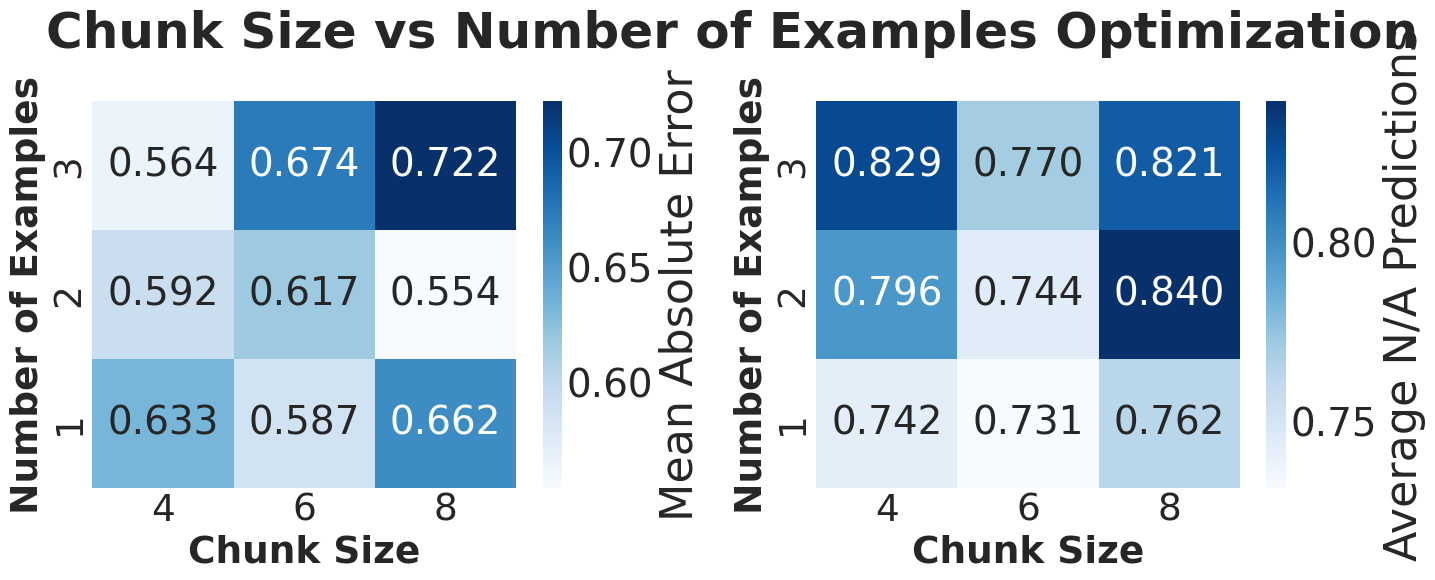

In [ ]:
def parse_filename(filename):
    """
    Extracts chunk size and number of examples from filename
    
    Parameters
    ----------
    filename : string
        Filename like "chunk_4_step_2_examples_1_embedding_results_analysis.jsonl"
    
    Returns
    -------
    tuple
        (chunk_size, number_of_examples) or (None, None) if parsing fails
    """
    pattern = r'chunk_(\d+)_step_\d+_examples_(\d+)_'
    match = re.search(pattern, filename)
    if match:
        chunk_size = int(match.group(1))
        num_examples = int(match.group(2))
        return chunk_size, num_examples
    return None, None

def calculate_overall_metrics(jsonl_file, ground_truth_df):
    """
    Calculates overall MAE and N/A count across all PHQ8 questions for a single file
    
    Parameters
    ----------
    jsonl_file : string
        Path to the JSONL file
    ground_truth_df : pandas dataframe
        DataFrame containing ground truth scores
    
    Returns
    -------
    tuple
        (mean_mae, total_na_count) across all questions
    """
    predicted_data = load_jsonl(jsonl_file)
    
    all_maes = []
    all_na_counts = []
    
    for question in phq8_questions:
        predicted_scores, ground_truth_scores, participant_ids, na_count = extract_scores_for_question(
            predicted_data, ground_truth_df, question
        )
        
        cm, na_count, accuracy_available = create_heatmap_with_na(
            predicted_scores, ground_truth_scores, question, na_count
        )
        
        if not np.isnan(accuracy_available):
            all_maes.append(accuracy_available)
        all_na_counts.append(na_count)
    
    mean_mae = np.mean(all_maes) if all_maes else np.nan
    total_na_count = np.sum(all_na_counts)
    
    return mean_mae, total_na_count

def create_comparison_heatmaps(jsonl_files, ground_truth_df, jsonl_files_2=None, jsonl_files_3=None):
    """
    Creates two 4x4 heatmaps comparing chunk_size vs number_of_examples
    
    Parameters
    ----------
    jsonl_files : list
        List of paths to JSONL files
    ground_truth_df : pandas dataframe
        DataFrame containing ground truth scores
    jsonl_files_2 : list, optional
        Second set of JSONL files to average with jsonl_files
    jsonl_files_3 : list, optional
        Third set of JSONL files to average with jsonl_files
    """
    # Define the ordering for chunk sizes and number of examples
    chunk_sizes = [4, 6, 8]
    num_examples = [1, 2, 3]
    
    mae_matrix = np.full((3, 3), np.nan)
    na_matrix = np.full((3, 3), np.nan)
    
    # Check if we need to average multiple file sets
    file_sets = [jsonl_files]
    if jsonl_files_2 is not None and len(jsonl_files_2) == len(jsonl_files):
        file_sets.append(jsonl_files_2)
    if jsonl_files_3 is not None and len(jsonl_files_3) == len(jsonl_files):
        file_sets.append(jsonl_files_3)
    
    # Process each file position across all sets
    for file_idx in range(len(jsonl_files)):
        files_to_average = [file_set[file_idx] for file_set in file_sets]
        
        # Parse filename from first file to get chunk_size and num_example
        filename = files_to_average[0].split('/')[-1]
        chunk_size, num_example = parse_filename(filename)
        
        if chunk_size and num_example:
            if chunk_size in chunk_sizes and num_example in num_examples:
                chunk_idx = chunk_sizes.index(chunk_size)
                example_idx = num_examples.index(num_example)
                
                # Calculate metrics for each file and average them
                mae_values = []
                na_values = []
                
                for jsonl_file in files_to_average:
                    mean_mae, total_na = calculate_overall_metrics(jsonl_file, ground_truth_df)
                    total_na = total_na/(27*8)
                    mae_values.append(mean_mae)
                    na_values.append(total_na)
                
                # Average the results
                avg_mae = np.mean(mae_values)
                avg_na = np.mean(na_values)
                
                mae_matrix[example_idx, chunk_idx] = avg_mae
                na_matrix[example_idx, chunk_idx] = avg_na
                
                print(f"Processed: chunk_{chunk_size}_examples_{num_example} - MAE: {avg_mae:.3f}, N/A: {avg_na:.3f} (averaged from {len(files_to_average)} files)")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Chunk Size vs Number of Examples Optimization', fontsize=30, fontweight='bold', y=0.98)
    
    # Mean Absolute Error
    sns.heatmap(mae_matrix, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=chunk_sizes,
                yticklabels=num_examples,
                ax=axes[0], annot_kws={'size': 29},
                cbar_kws={'label': 'Mean Absolute Error'})
    cbar = axes[0].collections[0].colorbar
    cbar.ax.tick_params(labelsize=27)
    cbar.set_label('Mean Absolute Error', fontsize=27)
    axes[0].tick_params(axis='both', which='major', labelsize=29)
    axes[0].set_xlabel('Chunk Size', fontsize=27, fontweight='bold')
    axes[0].set_ylabel('Number of Examples', fontsize=27, fontweight='bold')
    axes[0].invert_yaxis()
    
    # N/A Predictions
    sns.heatmap(na_matrix, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=chunk_sizes,
                yticklabels=num_examples,
                ax=axes[1], annot_kws={'size': 29},
                cbar_kws={'label': 'Average N/A Predictions'})
    cbar = axes[1].collections[0].colorbar
    cbar.ax.tick_params(labelsize=27)
    cbar.set_label('Average N/A Predictions', fontsize=27)
    axes[1].tick_params(axis='both', which='major', labelsize=29)
    axes[1].set_xlabel('Chunk Size', fontsize=27, fontweight='bold')
    axes[1].set_ylabel('Number of Examples', fontsize=27, fontweight='bold')
    axes[1].invert_yaxis()
    
    plt.tight_layout(pad=2.0)
    plt.savefig(r"/data/users2/agreene46/hyperparameter_matrix.pdf", bbox_inches='tight', dpi=300)
    plt.show()
    
    return mae_matrix, na_matrix

# First jsonl files is the main one. If you put equal amounts of jsonl files, in the same format, in jsonl_files_2 and 3 it'll average them with the first files on the graph

jsonl_files = [
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_4_step_2_examples_1_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_4_step_2_examples_2_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_4_step_2_examples_3_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_6_step_2_examples_1_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_6_step_2_examples_2_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_6_step_2_examples_3_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_8_step_2_examples_1_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_8_step_2_examples_2_embedding_results_analysis_1.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_8_step_2_examples_3_embedding_results_analysis_1.jsonl",
]

jsonl_files_2 = [
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_4_step_2_examples_1_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_4_step_2_examples_2_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_4_step_2_examples_3_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_6_step_2_examples_1_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_6_step_2_examples_2_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_6_step_2_examples_3_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_8_step_2_examples_1_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_8_step_2_examples_2_embedding_results_analysis_2.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_8_step_2_examples_3_embedding_results_analysis_2.jsonl",
]

jsonl_files_3 = [
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_4_step_2_examples_1_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_4_step_2_examples_2_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_4_step_2_examples_3_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_6_step_2_examples_1_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_6_step_2_examples_2_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_6_step_2_examples_3_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_8_step_2_examples_1_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_8_step_2_examples_2_embedding_results_analysis_3.jsonl",
    r"/data/users2/agreene46/ai-psychiatrist/3x_analysis_output/chunk_8_step_2_examples_3_embedding_results_analysis_3.jsonl",
]

# Create the heatmaps
mae_matrix, na_matrix = create_comparison_heatmaps(jsonl_files, ground_truth_df, jsonl_files_2, jsonl_files_3)

## t-SNE Embeddings Visualization

Running t-SNE on 5040 embeddings...


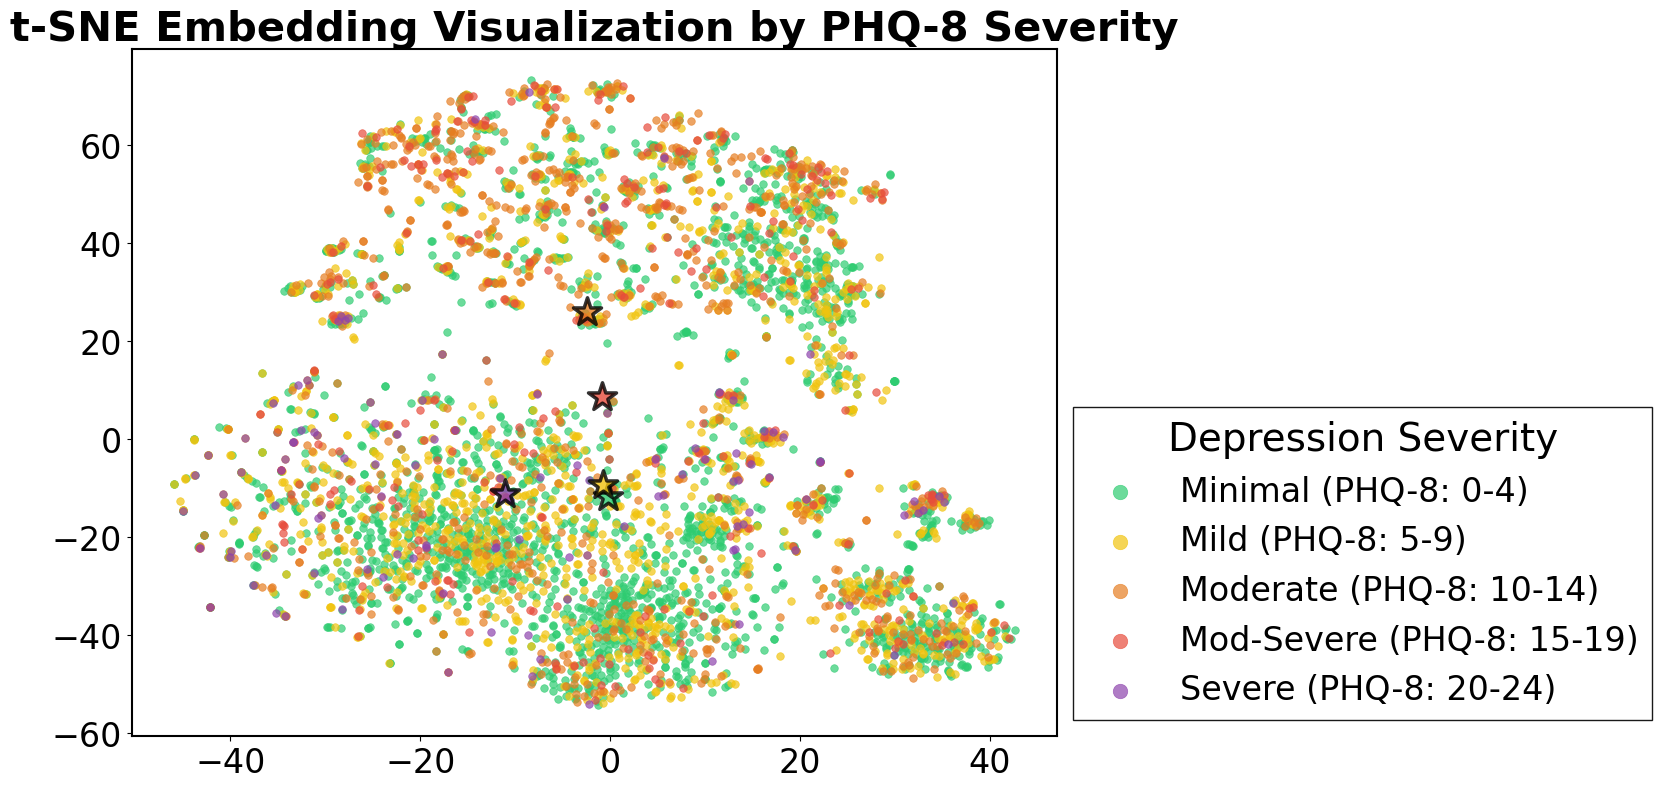


PHQ-8 Severity Distribution:
  Minimal: 2397 embeddings
  Mild: 1347 embeddings
  Moderate: 892 embeddings
  Mod-Severe: 290 embeddings
  Severe: 114 embeddings


In [11]:
dev_split_phq8 = pd.read_csv(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/dev_split_Depression_AVEC2017.csv")
train_split_phq8 = pd.read_csv(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/train_split_Depression_AVEC2017.csv")
# Combining the 2 dataframes
phq8_ground_truths = pd.concat([dev_split_phq8, train_split_phq8], ignore_index=True)


def load_embeddings_from_pkl(pkl_path):
    """
    Extract embeddings, labels, and texts from pickle file.
    
    Args:
        pkl_path: Path to pickle file containing participant embeddings data
    
    Returns:
        tuple: (embeddings_array, participant_labels, chunk_texts)
            - embeddings_array: NumPy array of embedding vectors
            - participant_labels: List of participant IDs for each embedding
            - chunk_texts: List of text chunks corresponding to each embedding
    """
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    
    embeddings = []
    participant_labels = []
    chunk_texts = []
    
    for participant_id, chunks_array in data.items():
        for chunk_text, embedding_vector in chunks_array:
            embeddings.append(embedding_vector)
            participant_labels.append(participant_id)
            chunk_texts.append(chunk_text)
    
    return np.array(embeddings), participant_labels, chunk_texts

def get_phq8_severity(score):
    """
    Map PHQ-8 score to severity category.
    
    Args:
        score: PHQ-8 numerical score (0-24)
    
    Returns:
        str: Severity category ('Minimal', 'Mild', 'Moderate', 'Mod-Severe', 'Severe', or 'Unknown')
    """
    if 0 <= score <= 4:
        return 'Minimal'
    elif 5 <= score <= 9:
        return 'Mild'
    elif 10 <= score <= 14:
        return 'Moderate'
    elif 15 <= score <= 19:
        return 'Mod-Severe'
    elif 20 <= score <= 24:
        return 'Severe'
    else:
        return 'Unknown'

def visualize_tsne_with_phq8(pkl_path, phq8_ground_truths, n_iter=1000, perplexity=30, 
                              figsize=(12, 8), random_state=42):
    """
    Create and display t-SNE visualization of embeddings colored by PHQ-8 severity.
    
    Args:
        pkl_path: Path to pickle file containing embeddings
        phq8_ground_truths: DataFrame with 'Participant_ID' and 'PHQ8_Score' columns
        n_iter: Number of t-SNE iterations (default: 1000)
        perplexity: t-SNE perplexity parameter (default: 30)
        figsize: Figure size tuple (default: (12, 8))
        random_state: Random seed for reproducibility (default: 42)
    
    Returns:
        tuple: (embeddings_2d, participant_labels, severities, phq8_scores)
            - embeddings_2d: 2D t-SNE coordinates
            - participant_labels: List of participant IDs
            - severities: List of severity categories
            - phq8_scores: List of PHQ-8 scores
    """
    embeddings, participant_labels, chunk_texts = load_embeddings_from_pkl(pkl_path)
    
    # Map each embedding to PHQ-8 severity
    severities = []
    phq8_scores = []
    
    for participant_id in participant_labels:
        participant_data = phq8_ground_truths.loc[
            phq8_ground_truths['Participant_ID'] == participant_id
        ]
        
        if len(participant_data) > 0:
            phq8_score = participant_data['PHQ8_Score'].iloc[0]
            phq8_scores.append(phq8_score)
            severities.append(get_phq8_severity(phq8_score))
        else:
            phq8_scores.append(np.nan)
            severities.append('Unknown')
    
    # Perform t-SNE
    tsne = TSNE(
        n_components=2,
        metric='cosine',
        method='barnes_hut',
        n_iter=n_iter,
        perplexity=perplexity,
        random_state=random_state,
        init='random'
    )
    
    print(f"Running t-SNE on {len(embeddings)} embeddings...")
    embeddings_2d = tsne.fit_transform(embeddings)
    
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    ax.set_facecolor('white')
    
    severity_colors = {
        'Minimal': '#2ecc71',           # Green
        'Mild': '#f1c40f',              # Yellow
        'Moderate': '#e67e22',          # Orange
        'Mod-Severe': '#e74c3c', # Red
        'Severe': '#8e44ad',            # Purple
        'Unknown': '#95a5a6'            # Gray
    }

    # Order for legend
    severity_order = ['Minimal', 'Mild', 'Moderate', 'Mod-Severe', 'Severe']
    
    # Dictionary to store centroids
    centroids = {}

    # Plot each severity level
    for severity in severity_order:
        if severity in severities:
            mask = np.array([s == severity for s in severities])
            severity_points = embeddings_2d[mask]
            
            ax.scatter(
                severity_points[:, 0],
                severity_points[:, 1],
                c=severity_colors[severity],
                label=f'{severity} (PHQ-8: {get_score_range(severity)})',
                alpha=0.7,
                s=30,
                edgecolors=severity_colors[severity],
                linewidths=0.5
            )
            
            # Calculate and plot centroid
            if len(severity_points) > 0:
                centroid = np.median(severity_points, axis=0)
                centroids[severity] = centroid
                
                ax.scatter(
                    centroid[0],
                    centroid[1],
                    c=severity_colors[severity],
                    s=450,
                    marker='*',
                    edgecolors='black',
                    linewidths=2.5,
                    zorder=10,
                    alpha=0.8,
                    label=None
                )
    
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.tick_params(axis='both', which='major', labelsize=24)
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    
    ax.set_title(
        f't-SNE Embedding Visualization by PHQ-8 Severity',
        fontsize=30,
        fontweight='bold'
    )
    
    legend = ax.legend(
        title='Depression Severity',
        loc='lower left',
        bbox_to_anchor=(1.00, 0),
        frameon=True,
        fancybox=False,
        framealpha=0.9,
        fontsize=24,
        title_fontsize=28,
        markerscale=1.9
    )

    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Room for the legend
    plt.savefig(r"/data/users2/agreene46/t-SNE_visual.pdf", bbox_inches='tight', dpi=300)
    plt.show()
    
    print("\nPHQ-8 Severity Distribution:")
    severity_counts = pd.Series(severities).value_counts()
    for severity in severity_order:
        if severity in severity_counts.index:
            print(f"  {severity}: {severity_counts[severity]} embeddings")
    
    return embeddings_2d, participant_labels, severities, phq8_scores

def get_score_range(severity):
    """
    Get PHQ-8 score range for severity level.
    
    Args:
        severity: Severity category string
    
    Returns:
        str: Score range (e.g., '0-4') or 'N/A' if severity not found
    """
    ranges = {
        'Minimal': '0-4',
        'Mild': '5-9',
        'Moderate': '10-14',
        'Mod-Severe': '15-19',
        'Severe': '20-24'
    }
    return ranges.get(severity, 'N/A')

phq8_ground_truths = pd.concat([dev_split_phq8, train_split_phq8], ignore_index=True)

# Visualize with PHQ-8 severity coloring
embeddings_2d, labels, severities, scores = visualize_tsne_with_phq8(
    pkl_path=r"/data/users2/agreene46/ai-psychiatrist/chunk_8_step_2_participant_embedded_transcripts.pkl",
    phq8_ground_truths=phq8_ground_truths,
    n_iter=2000,
    perplexity=75
)